In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, cohen_kappa_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from xgboost import XGBClassifier

In [2]:
# Import custom code
sys.path.insert(0, '..')
from scripts.custom_functions import DELAY_CLASS

In [3]:
df = pd.read_csv('../data/preprocessed.csv')
df.head()

,vehicle_id,vehicle_in_transit,vehicle_bearing,vehicle_speed,occupancy_status,route_id,stop_id,stop_lat,stop_lon,stop_distance,...,day_of_week,hour,is_weekend,is_peak_hour,weather_Cloudy,weather_Drizzle,weather_Rain,incident_nearby,delay,delay_class
0,745,1,54.0,0.00000,1,34,7436,45.668193,-73.549411,99.375552,...,6,18,1,0,0,0,0,0,0.0,2
1,741,0,54.0,0.00000,2,34,4358,45.616888,-73.615098,457.895119,...,6,18,1,0,0,0,0,0,92.0,2
2,741,1,334.0,11.94454,1,34,7353,45.665987,-73.546685,199.293772,...,6,18,1,0,0,0,0,0,92.0,2
3,696,0,0.0,0.00000,2,48,3212,45.546494,-73.690543,284.130563,...,6,18,1,0,0,0,0,0,374.0,3
4,800,1,269.0,5.00004,2,102,1358,45.495629,-73.601030,188.007922,...,6,18,1,0,0,0,0,0,286.0,3


In [4]:
df = df.drop('delay', axis=1)

In [5]:
# Separate the features from the target variable
X = df.drop('delay_class', axis=1)
y = df['delay_class']

In [6]:
# Train-validation-test split (70-15-15) 
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Random Forest

In [7]:
# Train model
rf_base = RandomForestClassifier(n_estimators=20, random_state=42, class_weight='balanced')
rf_base.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=20,
                       random_state=42)

In [8]:
# Evaluate
y_pred = rf_base.predict(X_val)

In [9]:
f1_macro = f1_score(y_test, y_pred, average='macro')
kappa = cohen_kappa_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
labels = DELAY_CLASS.values()

In [10]:
print(f"Macro F1 Score: {f1_macro:.4f}")
print(f"Cohen’s Kappa: {kappa:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=labels))

Macro F1 Score: 0.1877
Cohen’s Kappa: 0.0016

Classification Report:
              precision    recall  f1-score   support

  Very Early       0.06      0.02      0.03      1191
       Early       0.04      0.00      0.00       754
     On Time       0.79      0.97      0.87     27908
        Late       0.12      0.01      0.02      3974
   Very Late       0.06      0.01      0.01      1340

    accuracy                           0.77     35167
   macro avg       0.22      0.20      0.19     35167
weighted avg       0.65      0.77      0.70     35167



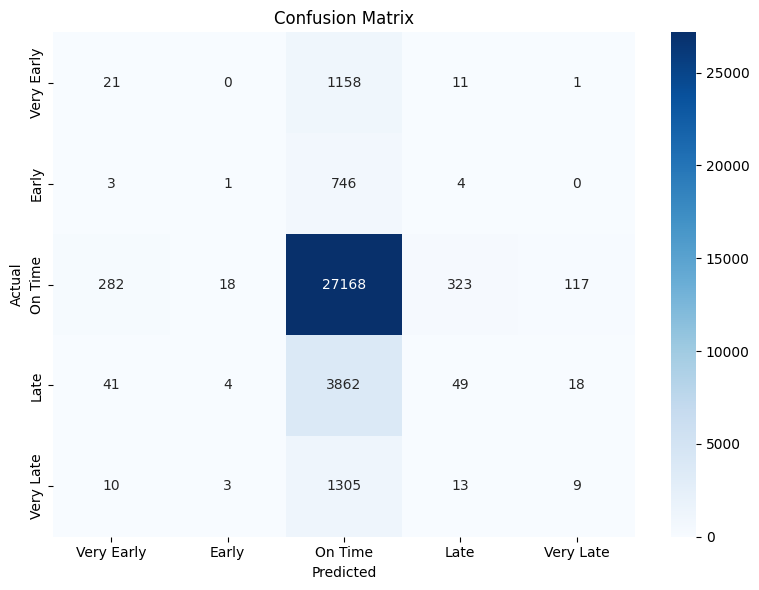

In [11]:
# Confusion matrix heatmap 
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [13]:
# Define parameter grid
param_dist = {
    'n_estimators': [100, 200, 400, 600],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample']
}

In [14]:
# Initialize base model
rf = RandomForestClassifier(random_state=42)

In [ ]:
# Randomized search with 5-fold CV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10, 
    cv=5,
    verbose=2,
    scoring='f1_macro',  # optimize for macro F1
    n_jobs=-1,
    random_state=42
)

# Fit search
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time= 3.9min
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time= 3.9min
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time= 3.9min
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time= 3.9min
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time= 4.0min
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimato

KeyboardInterrupt: 

In [ ]:
# Best model
best_rf = random_search.best_estimator_

In [ ]:
# Predict
y_pred = best_rf.predict(X_test)

In [ ]:
# Evaluate
from sklearn.metrics import f1_score, cohen_kappa_score, classification_report
print("Best Params:", random_search.best_params_)
print("Macro F1:", f1_score(y_test, y_pred, average='macro'))
print("Kappa:", cohen_kappa_score(y_test, y_pred))
print("\nReport:\n", classification_report(y_test, y_pred))

In [ ]:
# Feature importances
rf_tuned = rf_base
importances = rf_tuned.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_tuned.estimators_], axis=0)

In [ ]:
# Sort predictors
feature_importances = pd.Series(importances, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)
feature_importances

In [ ]:
# Plot the impurity-based importance (MDI)
fig, ax = plt.subplots()
feature_importances.plot.bar(yerr=std, ax=ax)
ax.set_title('Feature importances using MDI')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()
plt.savefig('../images/mdi_rf_tuned.png', bbox_inches='tight')
plt.show()